In [2]:
import pandas as pd
from collections import Counter
import math
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import pandas as pd


## Load the data and create the news_id and full_text columns

In [3]:

# Load fake and real news datasets
pf_fake = pd.read_csv("../data/raw/PolitiFact_fake_news_content.csv")
pf_real = pd.read_csv("../data/raw/PolitiFact_real_news_content.csv")

# Concatenate them into a full dataset
df_full = pd.concat([pf_real, pf_fake], ignore_index=True)

# Append news_id from PolitiFactNews.txt
with open('../data/raw/PolitiFactNews.txt', 'r') as file:
    news_ids = [line.strip() for line in file]

df_full["news_id"] = news_ids

# Load train and test id's
with open('../data/processed/FakeNewsNet/trainIds.txt', 'r') as file:
    train_values = [line.strip() for line in file]
with open('../data/processed/FakeNewsNet/testIds.txt', 'r') as file:
    test_values = [line.strip() for line in file]

# Create train and test data sets
df_train = df_full[df_full['news_id'].isin(train_values)]
df_test = df_full[df_full['news_id'].isin(test_values)]

df_train["full_text"] = df_train["title"] + " " + df_train["text"]
df_test["full_text"] = df_test["title"] + " " + df_test["text"]

# Create a label column stating whether the news is fake or real based on the news_id column
df_train["label"] = df_train["news_id"].apply(lambda x: "fake" if x.split("_")[1].lower() == "fake" else "real")
df_test["label"] = df_test["news_id"].apply(lambda x: "fake" if x.split("_")[1].lower() == "fake" else "real")


C:\Users\Lasse\AppData\Local\Temp\ipykernel_3736\2085749913.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["full_text"] = df_train["title"] + " " + df_train["text"]
C:\Users\Lasse\AppData\Local\Temp\ipykernel_3736\2085749913.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["full_text"] = df_test["title"] + " " + df_test["text"]
C:\Users\Lasse\AppData\Local\Temp\ipykernel_3736\2085749913.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

## Creating a TF-IDF representation.

In [4]:
# Download the stopwords dataset
nltk.download('stopwords', quiet=True)


def tokenize(text, stemmer, stop_words):
    """Tokenize text, stem, and remove stop words."""
    tokens = re.findall(r'\b\w+\b', text.lower())
    return [stemmer.stem(token) for token in tokens if token not in stop_words]

def compute_tfidf_train(df, column_name):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    # Tokenize, stem and compute term frequency for each document
    df['tf'] = df[column_name].apply(lambda x: Counter(tokenize(x, stemmer, stop_words)))

    # Create a list of all unique words in the corpus
    all_unique_words = list(set(word for tf in df['tf'] for word in tf.keys()))

    # Compute the number of documents in which each word appears
    word_document_count = Counter(word for tf in df['tf'] for word in tf.keys())

    # Compute the total number of documents
    total_documents = len(df)

    # Compute inverse document frequency for each word
    idf = {word: math.log(total_documents / count) for word, count in word_document_count.items()}

    # Compute TF-IDF for each word in each document and ensure that all words in the corpus are represented
    def calculate_tfidf(tf):
        return {word: tf.get(word, 0)/sum(tf.values()) * idf[word] for word in all_unique_words}

    df['tfidf'] = df['tf'].apply(calculate_tfidf)

    return df['tfidf'], all_unique_words, idf


# We create a separate function for the test data because we need to use the IDF from the training data
def compute_tfidf_test(df, column_name, train_unique_words, train_idf):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    df['tf'] = df[column_name].apply(lambda x: Counter(tokenize(x, stemmer, stop_words)))

    # Compute TF-IDF for each word in each document using the vocabulary and IDF from training data
    def calculate_tfidf(tf):
        return {word: tf.get(word, 0)/sum(tf.values()) * train_idf[word] for word in train_unique_words}

    df['tfidf'] = df['tf'].apply(calculate_tfidf)

    return df['tfidf']

# For the training data
df_train['tfidf'], train_unique_words, train_idf = compute_tfidf_train(df_train, 'full_text')

# For the test data
df_test['tfidf'] = compute_tfidf_test(df_test, 'full_text', train_unique_words, train_idf)

df_train.to_csv("../data/processed/FakeNewsNet/train.csv", index=False)
df_test.to_csv("../data/processed/FakeNewsNet/test.csv", index=False)


C:\Users\Lasse\AppData\Local\Temp\ipykernel_3736\884586417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tf'] = df[column_name].apply(lambda x: Counter(tokenize(x, stemmer, stop_words)))
C:\Users\Lasse\AppData\Local\Temp\ipykernel_3736\884586417.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tfidf'] = df['tf'].apply(calculate_tfidf)
C:\Users\Lasse\AppData\Local\Temp\ipykernel_3736\884586417.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

## Word clouds for fake and real news

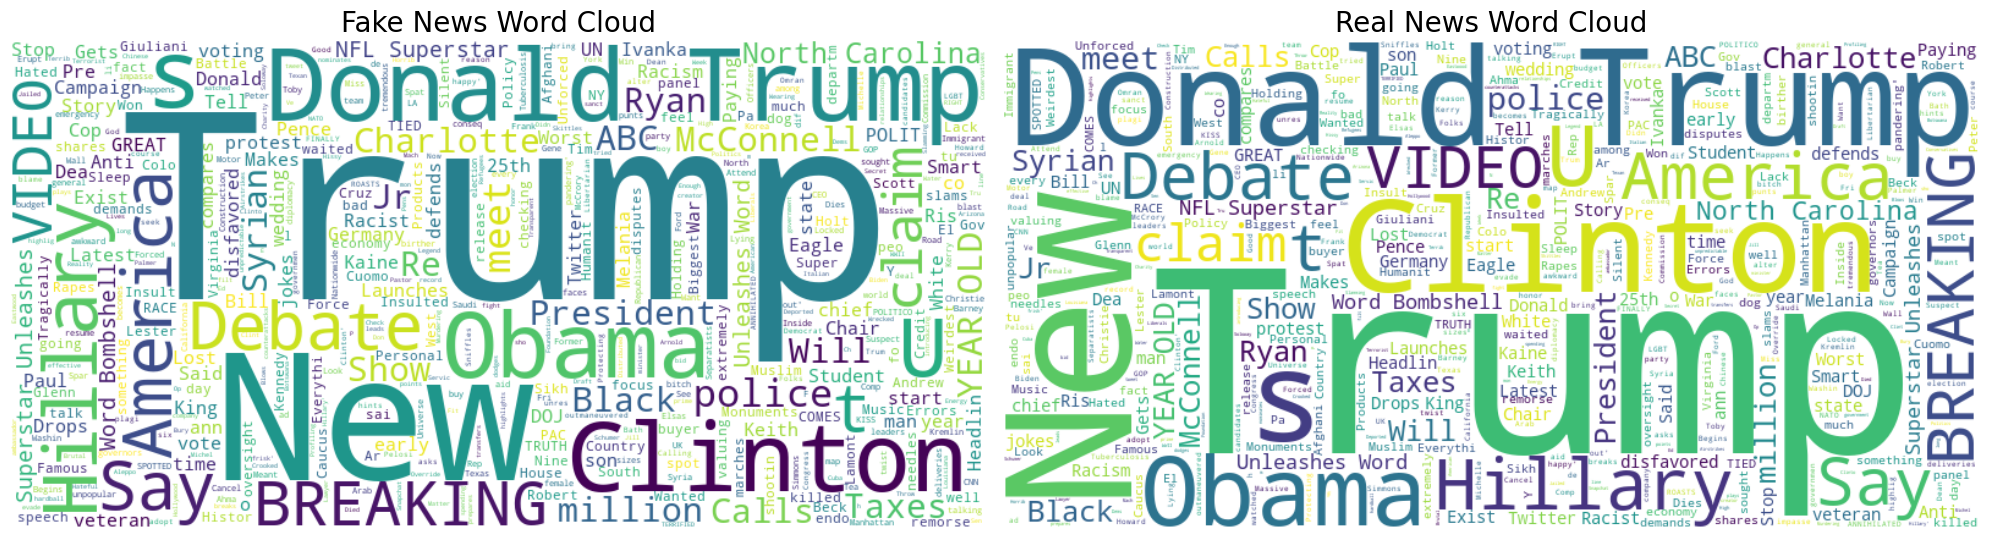

In [5]:
# Create word cloud for the fake news
from wordcloud import WordCloud
import matplotlib.pyplot as plt

pf_fake["full_text"] = pf_fake["title"] + " " + pf_fake["text"]
pf_real["full_text"] = pf_real["title"] + " " + pf_real["text"]

# Create a word cloud for the fake news
wordcloud_fake = WordCloud(background_color="white",
                           max_words=5000,
                           contour_width=3,
                           contour_color='steelblue',
                           width=800,  
                           height=400  
                          )
wordcloud_fake.generate(pf_fake["full_text"].to_string())
wordcloud_fake.to_image()

# Create a word cloud for the real news
wordcloud_real = WordCloud(background_color="white",
                           max_words=5000,
                           contour_width=3,
                           contour_color='steelblue',
                           width=800,  
                           height=400  
                          )
wordcloud_real.generate(pf_real["full_text"].to_string())
wordcloud_real.to_image()

# Set up the figure and axes
fig, axarr = plt.subplots(1, 2, figsize=(20, 10))  # 1x2 grid of plots, adjust the figure size as needed

# Display the fake news word cloud on the left subplot
axarr[0].imshow(wordcloud_fake, interpolation='bilinear')
axarr[0].axis('off')
axarr[0].set_title("Fake News Word Cloud", fontsize=20)

# Display the real news word cloud on the right subplot
axarr[1].imshow(wordcloud_real, interpolation='bilinear')  # Make sure you're showing wordcloud_real here
axarr[1].axis('off')
axarr[1].set_title("Real News Word Cloud", fontsize=20)

# Adjust the spacing between the plots if necessary
plt.tight_layout()

plt.show()





## PCA on the training data

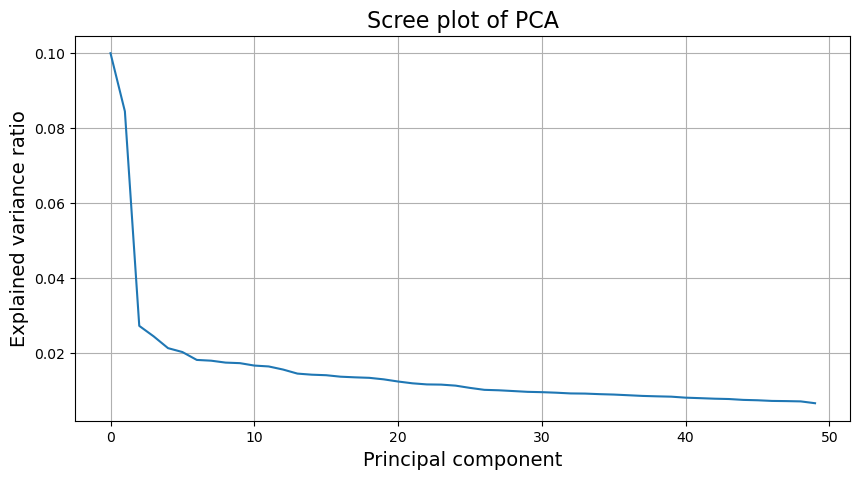

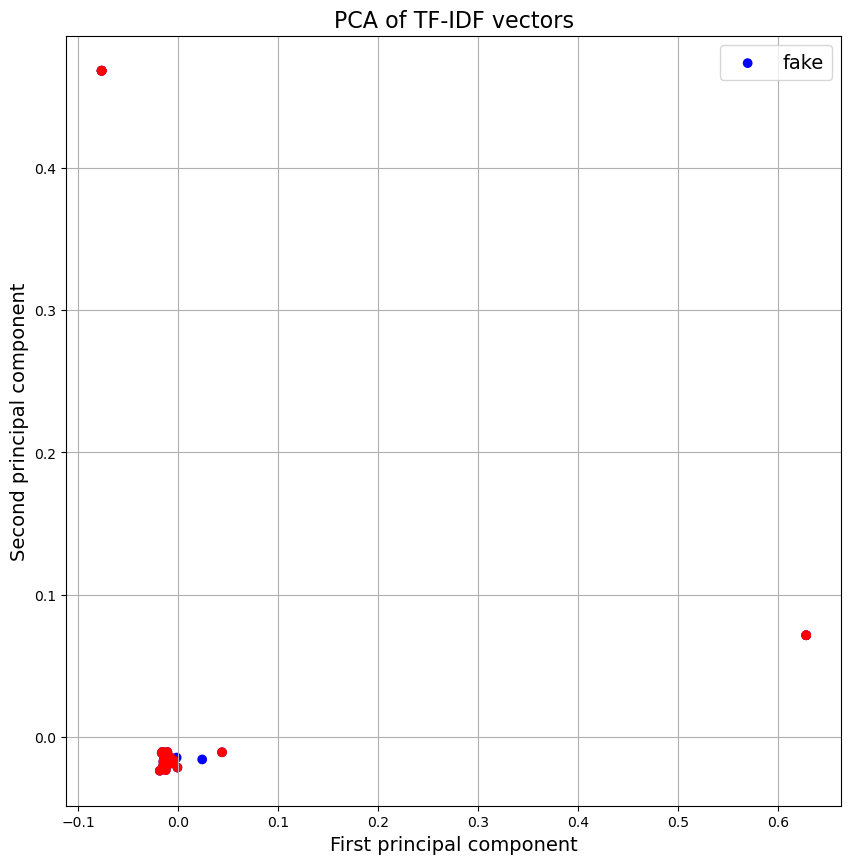

In [14]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction import DictVectorizer
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import plot

# Convert the dictionaries in the "tfidf" column into a matrix
dict_vectorizer = DictVectorizer(sparse=False)
tfidf_matrix = dict_vectorizer.fit_transform(df_train['tfidf'])

# Compute PCA of the TF-IDF vectors
pca = PCA(n_components=50)
pca.fit(tfidf_matrix)

# Transform the TF-IDF matrix using the PCA model
tfidf_pca = pca.transform(tfidf_matrix)

plt.figure(figsize=(10, 5))
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal component', fontsize=14)
plt.ylabel('Explained variance ratio', fontsize=14)
plt.title('Scree plot of PCA', fontsize=16)
plt.grid(True)
plt.show()

# Create a scatter plot of the two first principal components
plt.figure(figsize=(10, 10))
plt.scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], c=df_train['label'].map({'fake': 'red', 'real': 'blue'}), cmap='coolwarm')
plt.xlabel('First principal component', fontsize=14)
plt.ylabel('Second principal component', fontsize=14)
plt.title('PCA of TF-IDF vectors', fontsize=16)
plt.grid(True)
plt.legend(['fake', 'real'], fontsize=14)
plt.show()

In [16]:
tfidf_matrix.shape

(192, 5710)

c:\Users\Lasse\anaconda3\envs\bachelorproject\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Lasse\anaconda3\envs\bachelorproject\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


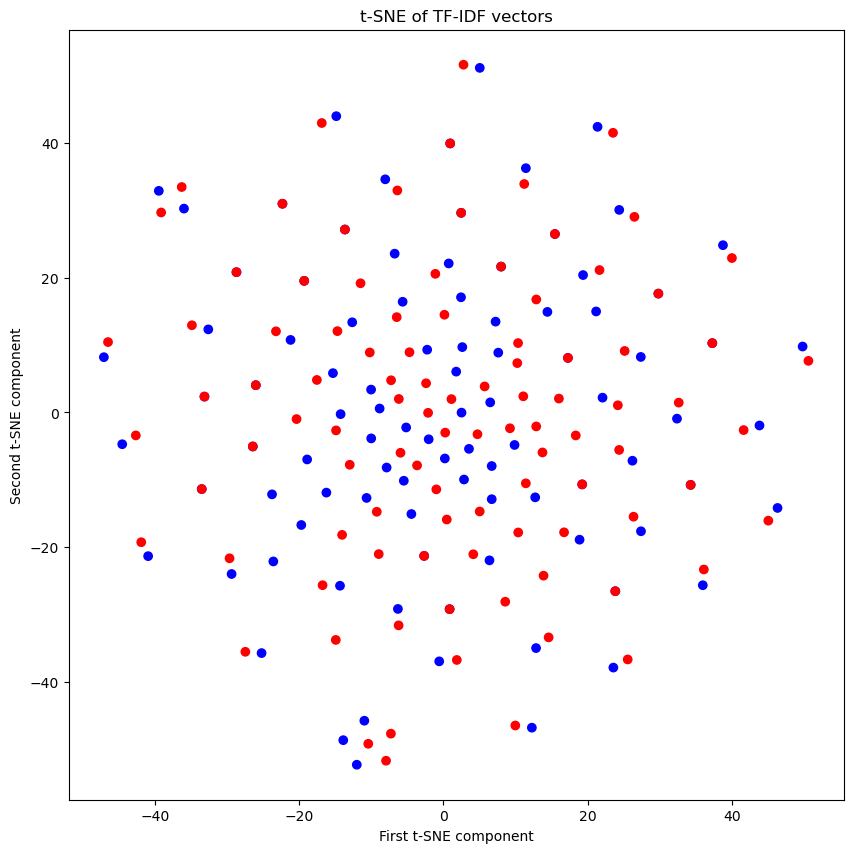

In [7]:
# Create a t-SNE scatter plot of the trainind data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Compute t-SNE of the TF-IDF vectors
tsne = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=1000)
tsne.fit(tfidf_matrix)

# Transform the TF-IDF matrix using the t-SNE model
tfidf_tsne = tsne.fit_transform(tfidf_matrix)

# Create a scatter plot of the two first t-SNE components
plt.figure(figsize=(10, 10))
plt.scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], c=df_train['label'].map({'fake': 'red', 'real': 'blue'}))
plt.xlabel('First t-SNE component')
plt.ylabel('Second t-SNE component')
plt.title('t-SNE of TF-IDF vectors')
plt.show()


In [9]:
# # Create a UMAP scatter plot of the training data
# import umap.umap_ as umap
# import matplotlib.pyplot as plt

# # Compute UMAP of the TF-IDF vectors
# umap = umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.1)
# umap.fit(tfidf_matrix)

# # Transform the TF-IDF matrix using the UMAP model
# tfidf_umap = umap.fit_transform(tfidf_matrix)

# # Create a scatter plot of the two first UMAP components
# plt.figure(figsize=(10, 10))
# plt.scatter(tfidf_umap[:, 0], tfidf_umap[:, 1], c=df_train['label'].map({'fake': 'red', 'real': 'blue'}))
# plt.xlabel('First UMAP component')
# plt.ylabel('Second UMAP component')
# plt.title('UMAP of TF-IDF vectors')
# plt.show()


In [ ]:
# Function to calculate the cosine similarity between two vectors

def cosine_similarity(vector1, vector2):
    """Calculate the cosine similarity between two vectors."""
    dot_product = sum(p*q for p, q in zip(vector1, vector2))
    magnitude = math.sqrt(sum([val**2 for val in vector1])) * math.sqrt(sum([val**2 for val in vector2]))
    if not magnitude:
        return 0
    return dot_product/magnitude

